# Computing a PCA of tile-level CHARM features

This notebook exemplifies working with the computed CHARM features. 

We will load several Wells of time resolved tile-level features, compute their PCA, and show that single cell biologically relevant information are indeed present in unsupervised features computed on tiles without segmentation.

!! Some cells take a very long time to run (querying the rows from the table in particular)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shelve
import random
from pandas import Series,DataFrame,read_csv, merge,concat,read_hdf
#rom omero.gateway import BlitzGateway
import omero
from matplotlib.widgets import Slider
from matplotlib import gridspec
from sklearn.externals import joblib


from sklearn import random_projection
import sklearn.neighbors as nn
import sklearn.manifold as man
import sklearn.decomposition as dec
from sklearn.preprocessing import scale,robust_scale
from sklearn.metrics.pairwise import euclidean_distances

from idr_demo import connection
import tables

%matplotlib inline
plt.rcParams['image.cmap']='gray'


In [2]:
def getBulkAnnotationAsDf(screenID,conn):
#    Download the annotation file from a screen as a Pandas DataFrame
    sc=conn.getObject('Screen',screenID)
    for ann in sc.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName()=='bulk_annotations'):
                if (ann.getFile().getSize()> 147625090): #about 140Mb?
                    print "that's a big file..."
                    return None
                ofId=ann.getFile().getId()
                break


    original_file = omero.model.OriginalFileI(ofId, False)

    openTable = conn.c.sf.sharedResources().openTable(original_file)
    rowCount = openTable.getNumberOfRows()

    #table to df

    column_names = [col.name for col in openTable.getHeaders()]

    black_list = []
    column_indices = []
    for column_name in column_names:
        if column_name in black_list:
            continue
        column_indices.append(column_names.index(column_name))

    table_data = openTable.slice(column_indices, None)
    data = []
    for index in range(rowCount):
        row_values = [column.values[index] for column in table_data.columns]
        data.append(row_values)

    dfAnn=DataFrame(data)
    dfAnn.columns=column_names
    return dfAnn

In [22]:
def goneFishing(iid,x,y,t,df,nbrs,conn):
# Find and display nearest neighbours of a given tile

    qry=df[(df.x==x) & (df.y==y) & (df.ImageID==iid) & (df.t==t)].iloc[:,12:]

    dfq=df[df.ImageID!=iid]
    w=dfq.w.iloc[0]
    h=dfq.h.iloc[0]
    chan=0
    
 
    hook=getCondensationSubStack(iid,x,y,w,h,t,t+1,conn)    
    
    distances, indices = nbrs.kneighbors(qry)
    nnn=len(indices[0])
    tiles=np.zeros((h,w,nnn))
    for ind,ii in zip(indices[0],range(nnn)):
        iidcur=dfq.ImageID.iloc[ind]
        x=dfq.x.iloc[ind]
        y=dfq.y.iloc[ind]
        t=int(dfq.t.iloc[ind])
        tiles[:,:,ii]=getCondensationSubStack(iidcur,x,y,w,h,t,t+1,conn ) 

    
    d,r=divmod(nnn,4)
    plt.figure(figsize=(12,30))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
    ax0 = plt.subplot(gs[0,0])
    ax0.set_title('Original frame')
    ax0.imshow(hook)

    imc=buildComposite(tiles,d+(1&r),4,smpl=1)
#    plt.figure(figsize=(12,15))
    ax1 = plt.subplot(gs[1,0])
    ax1.set_title('Nearest neighbours')
    ax1.imshow(imc)
    

In [4]:
def getCondensationSubStack(imId,x,y,w,h,ti,tf,conn,chan=0):
#  Extract a substack of an image as a numpy array

    im = conn.getObject("Image", imId)
    pix=im.getPrimaryPixels()

    z=0;c=chan;
    tile = (x, y, w, h) 
    zctList = [(z, c, it, tile) for it in range(ti,tf)]
    planes = pix.getTiles(zctList)
    st=[]
    for plane in planes:
        st.append(plane)

    st=np.asarray(st)
    if tf>ti+1:
        st=np.rollaxis(st,0,3)
    else:
        st=np.squeeze(st)
    
    return st

In [5]:
def buildComposite(st,n,m,smpl=None):
    #nxm shots from st in a grid, as an image
    nr=st.shape[0]
    nc=st.shape[1]
    if smpl==None:
        smpl=st.shape[2]/(n*m)
    res=np.zeros((nr*n,nc*m))
    for i in range(n):
        for j in range(m):
            try:
                res[i*nr:i*nr+nr,j*nc:j*nc+nc]=st[:,:,(i*m+j)*smpl]
            except:
                break
    return res

In [26]:
def outOneStack(imId,x,y, df, con,alg='PCA',chan=0,title='First 5 PCA components of a stack'):
#    Plot PCA components along with tiles from the stack

    df=df[(df.x==x) & (df.y==y) & (df.ImageID==imId)].sort_values('t',ascending=True)

    plt.figure(figsize=(12,30))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 
    ax0 = plt.subplot(gs[0,0])
    ax0.set_title(title)
    ax0.set_xlabel('Time (frame)')
    ax0.set_ylabel('PCA components (a.u.)')
    if alg=='PCA':
        ax0.plot(df.PCA_0.values)
        ax0.plot(df.PCA_1.values,'r')
        ax0.plot(df.PCA_2.values,'g')
        ax0.plot(df.PCA_3.values,'y')
        ax0.plot(df.PCA_4.values,'m')
        ax0.plot(df.PCA_5.values,'c')
    elif alg=='DR':
        ax0.plot(df.DR_0.values)
        ax0.plot(df.DR_1.values,'r')
        ax0.plot(df.DR_2.values,'g')
        ax0.plot(df.DR_3.values,'y')
        ax0.plot(df.DR_4.values,'m')


    x,y,w,h=x,y,df.w.min(),df.h.min()
    #plateId,wellNb,x,y,w,h=492,5,dfst.x.min(),dfst.y.min(),dfst.w.min(),dfst.h.min()
    ti,tf=int(df.t.min()),int(df.t.max())
    st=getCondensationSubStack(imId,x,y,w,h,ti,tf, conn,chan)    
    
    imc=buildComposite(st,5,5)
#    plt.figure(figsize=(12,15))
    ax1 = plt.subplot(gs[1,0])
    ax1.imshow(imc)
    ax1.set_title('Mosaic from the corresponding stack, begins in the upper left, end in the lower right')
    return st

In [7]:
def data2df(data):
# convert an OMERO.table data structure to a dataframe, unpacking features array
    nrow=len(data.columns[0].values)
    nfeat=0
    for i in range(len(data.columns)):
        try:
            s=len(data.columns[i].values[0])
        except:
            s=1
        nfeat=nfeat+s

    featsAll=np.zeros((nrow,nfeat))

    nfeat=0
    featNames=[]
    for i in range(len(data.columns)):
        try:
            s=len(data.columns[i].values[0])
            for k in range(len(data.columns[i].values)):
                featsAll[k,nfeat:nfeat+s]=np.array(data.columns[i].values[k])

            for k in range(s):
                featNames.append(data.columns[i].name+str(k))

        except:
            s=1
            featsAll[:,nfeat]=np.array(data.columns[i].values)
            featNames.append(data.columns[i].name)
        nfeat=nfeat+s

    dfFeat=DataFrame(featsAll)
    dfFeat.columns=featNames
    
    return dfFeat

In [8]:
def rows2features(qr,concatenateC=True):
#extract selected rows from an OMERO.table
    maxr=10000  #else memory errors
    dfFeatPhen=DataFrame()
    k=-1 #in case there is less that maxr rows
    for k in range(len(qr)/maxr):
        data = featTable.readCoordinates(qr[k*maxr:(k+1)*maxr])
        data=data2df(data)
        dfFeatPhen=concat([dfFeatPhen,data])
        print str(k*maxr)+' to '+str((k+1)*maxr)

    if len(qr)%maxr!=0:
        data = featTable.readCoordinates(qr[(k+1)*maxr:])
        data=data2df(data)
        dfFeatPhen=concat([dfFeatPhen,data])
        print 'from '+str((k+1)*maxr)

        
    dfFeatPhen=dfFeatPhen.reset_index(drop=True)
    
    if concatenateC:
        featNames=dfFeatPhen.columns[0:12]
        for i in [0,1,2]:
            featNames=featNames.append(str(i)+'_'+dfFeatPhen.columns[12:])

        nf=dfFeatPhen.shape[1]-12
        dfFeat=np.zeros((dfFeatPhen.shape[0]/3,12+3*(nf)))
        for k,(name, grp) in enumerate(dfFeatPhen.groupby(['ImageID',u'x',u'y'])):
            dfFeat[k,0:12]=grp.iloc[0,0:12].values
            grp.sort_values('c',inplace=True)
            for i,(nr,r) in enumerate(grp.iterrows()):
                dfFeat[k,12+i*nf:(12+(i+1)*nf)]=r.iloc[12:].values


        dfFeaPhent=DataFrame(dfFeat)
        dfFeatPhen.columns=featNames

    
    return dfFeatPhen

## Loading Data

In [9]:
conn = connection()

In [10]:
scId=102 #Heriche et al., DNA condentation screen

#get annotations
dfAnn=getBulkAnnotationAsDf(scId,conn)

In [11]:
#loading the feature table 

sc=conn.getObject('Screen',scId)
#printing names of all files attached to the screen
for ann in sc.listAnnotations():
    if isinstance(ann, omero.gateway.FileAnnotationWrapper):
        print ann.getFile().getName()

#getting the fileAnnotation correponding to the features
#!!! not the full file
for ann in sc.listAnnotations():
    if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName()=='idr0002-heriche-condensation-screenA-plate-all.h5'):
                ofId=ann.getFile().getId()
            break
            
original_file = omero.model.OriginalFileI(ofId, False)

featTable = conn.c.sf.sharedResources().openTable(original_file)
featRowCount = featTable.getNumberOfRows()
print 'number of tiles with computed features:'+str(featRowCount)


idr0002-heriche-condensation-screenA-plate-all.h5
bulk_annotations
number of tiles with computed features:45490176


In [12]:
#cherry picking a few wells
plateCP=['plate1_1_013','plate2_2_007','plate2_2_007','plate3_4_034']
wellCP=[5,53,63,24]

we=[dfAnn[(dfAnn['Plate Name']==plateCP[i]) & (dfAnn['Well Number']==str(wellCP[i]))]['Well'] for i in range (4)]
we=concat(we)
print we

4       67089
436    164785
446    164879
887    289335
Name: Well, dtype: int64


In [13]:
#finding the rows of the table we are interested in
where="(WellID=="+str(we.values[0])+")|(WellID=="+str(we.values[1])+")|(WellID=="+str(we.values[2])+")|(WellID=="+str(we.values[3])+")"
qr=featTable.getWhereList(where, variables={}, start=0, stop=featRowCount, step=0)

#downloading them as a dataframe
maxr=10000  #else memory errors
df=DataFrame()
k=-1 #in case there is less that maxr rows
for k in range(len(qr)/maxr):
    data = featTable.readCoordinates(qr[k*maxr:(k+1)*maxr])
    data=data2df(data)
    df=concat([df,data])
    print str(k*maxr)+' to '+str((k+1)*maxr)

if len(qr)%maxr!=0:
    data = featTable.readCoordinates(qr[(k+1)*maxr:])
    data=data2df(data)
    df=concat([df,data])
    print 'from '+str((k+1)*maxr)

    
df=df[df.c==0]   #first channel is the one with chromosome information
df=df.reset_index(drop=True)


0 to 10000
10000 to 20000
20000 to 30000
30000 to 40000
40000 to 50000
50000 to 60000
60000 to 70000
70000 to 80000
80000 to 90000
90000 to 100000
100000 to 110000
110000 to 120000
120000 to 130000
130000 to 140000
140000 to 150000
150000 to 160000
160000 to 170000
from 170000


## computing PCA

In [14]:
#PCA of 4 wells
    
df=df[df.c==0]
dat=df.iloc[:,12:]
#keeping only the features which are not too discrete
#nbv=[len(dat[x].unique()) for x in df.iloc[:,12:]]
#dat=dat.iloc[:,np.array(nbv)>10]

dat=scale(dat)


pca=dec.PCA(n_components=250,svd_solver='randomized')
#pca=dec.RandomizedPCA(250)
#pca=dec.SparsePCA(250)
#pca=dec.KernelPCA(n_components=10,kernel='rbf')

pca.fit(dat)
datPCA=pca.transform(dat)
datPCA=DataFrame(datPCA)
datPCA.columns=['PCA_'+str(i) for i in range(datPCA.shape[1])]
df=df.reset_index(drop=True)
df=concat((df.iloc[:,0:12],datPCA),axis=1)
#transformer = random_projection.SparseRandomProjection(n_components=500)
#dat = transformer.fit_transform(dat)


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


## Visualisation

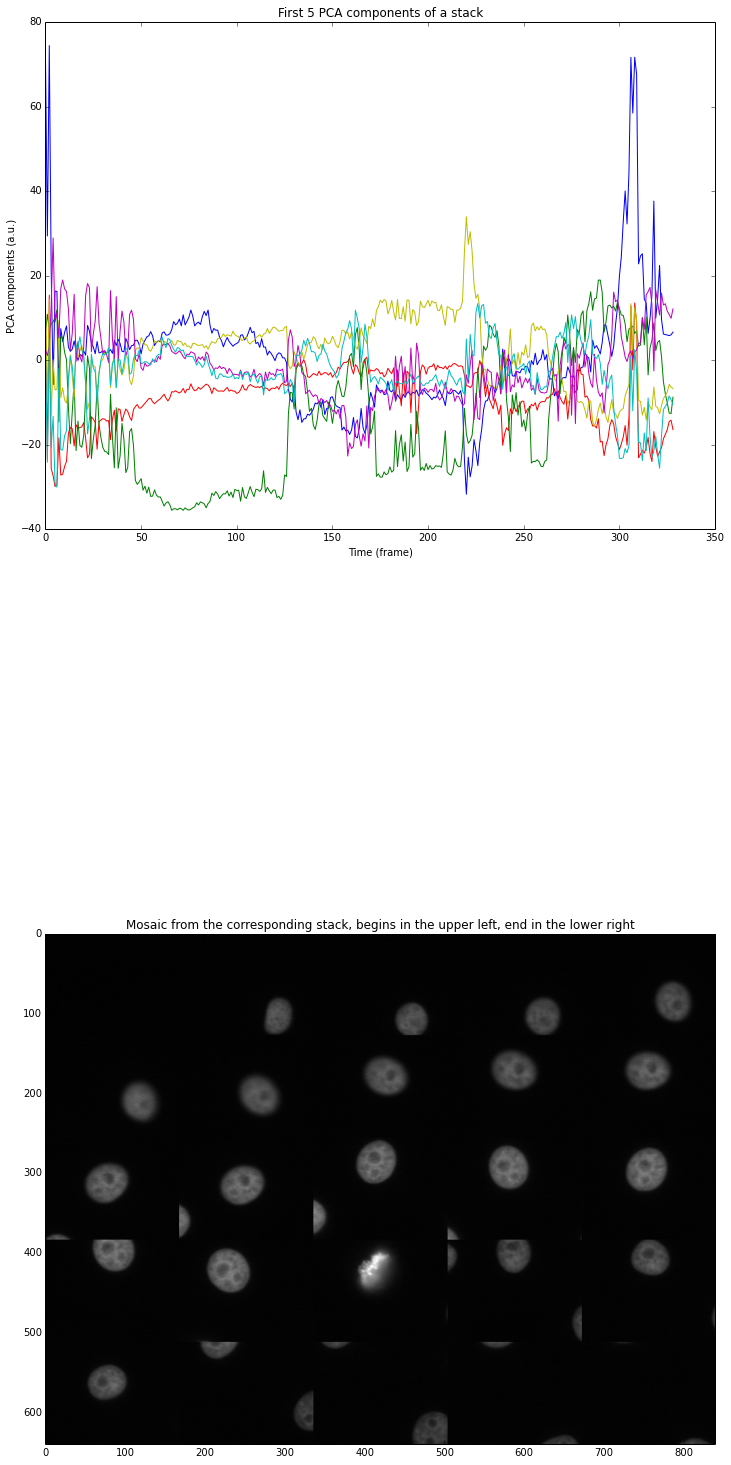

In [27]:
# Visualisation of one stack. 
# a Division is happening around t=220, and seem to have a clear signature, even with only 5 components
x,y=504,384 
imId=179719

st=outOneStack(imId,x,y, df,conn,alg='PCA',chan=0)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


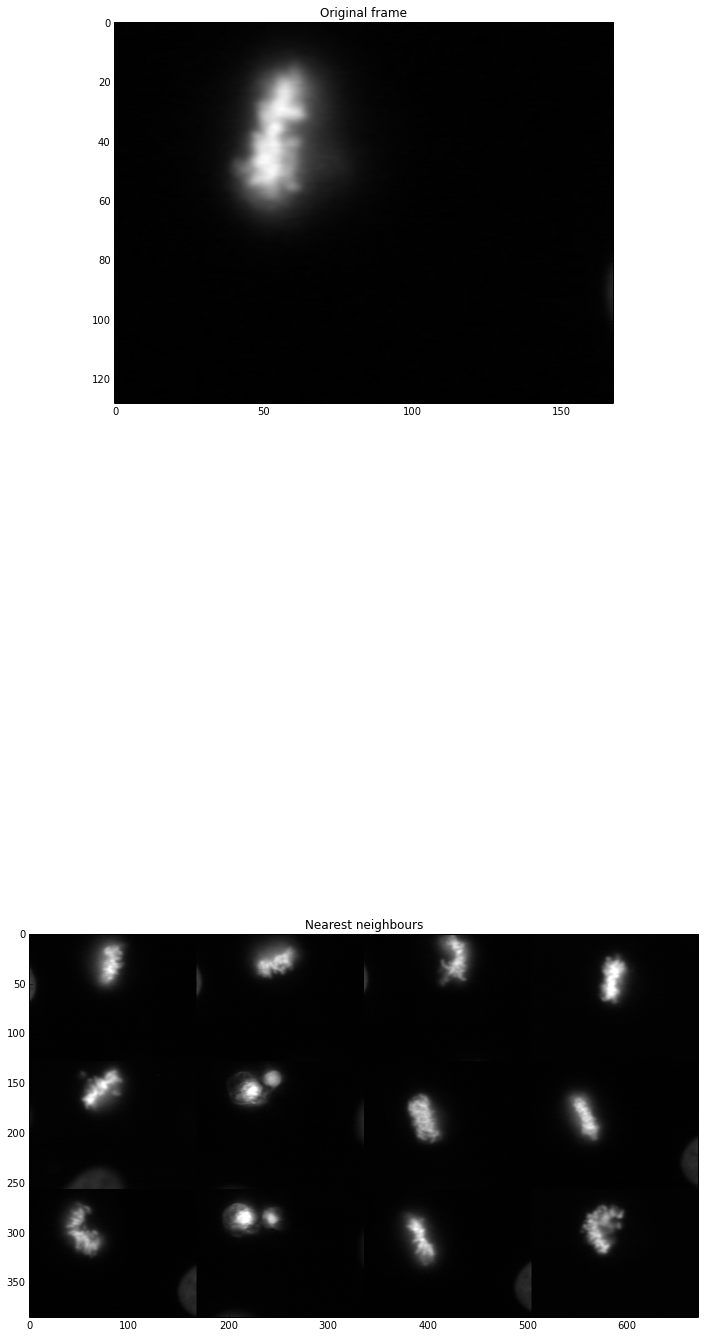

In [28]:
## Lokking for nearest neighbours of a given frame

iid,x,y,t=179719,504,384,220  #division at 220

dfq=df[df.ImageID!=iid] #excluding the image the query frame comes from
nbrs = nn.NearestNeighbors(n_neighbors=12, algorithm='ball_tree').fit(dfq.iloc[:,12:]) 


goneFishing(iid,x,y,t,df,nbrs,conn)